<a href="https://colab.research.google.com/github/Deca97/Anaerobic_Threshold_Test/blob/main/Test_Conconi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install fitdecode

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 5.9 MB/s eta 0:00:00


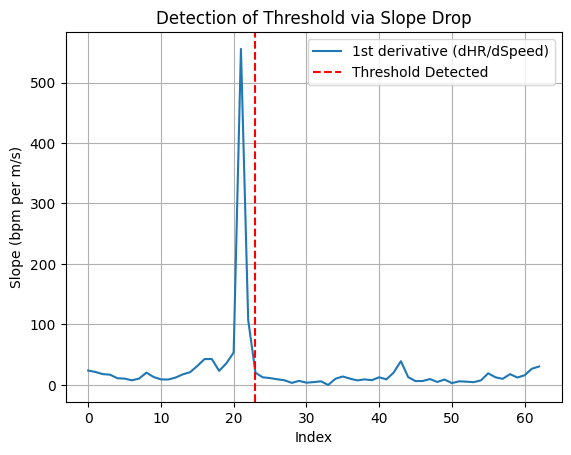

Estimated Anaerobic Threshold Heart Rate: 179 bpm
Estimated Anaerobic Threshold Pace: 3:16 min/km
Estimated Anaerobic Threshold Speed: 4.787 m/s
Slope before threshold: 16.55 bpm/(m/s)
Slope after threshold: 9.89 bpm/(m/s)


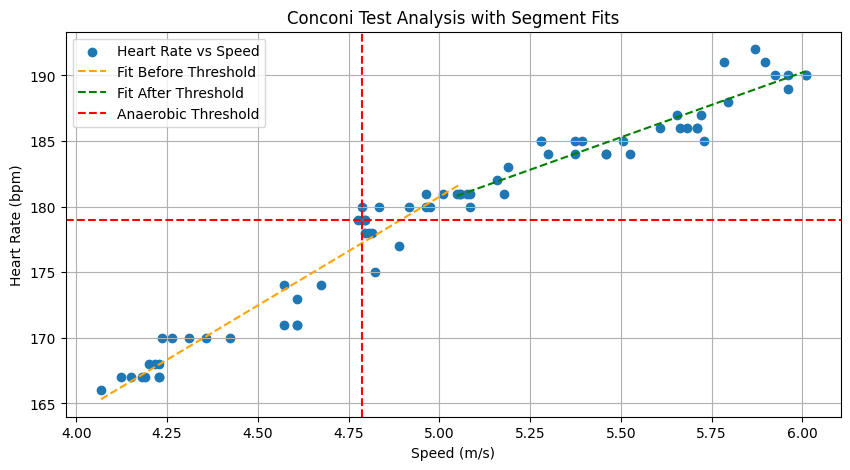

In [2]:
import fitdecode
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import numpy.polynomial.polynomial as poly


def get_conconi_data(fit_file_path):
    """
    Extracts heart rate and speed/pace data from a Garmin FIT file representing a Conconi test.
    """
    heart_rates = []
    speeds = []
    try:
        with fitdecode.FitReader(fit_file_path) as fit_file:
            for frame in fit_file:
                if frame.frame_type == fitdecode.FIT_FRAME_DATA and frame.name == "record":
                    heart_rate = frame.get_value('heart_rate')
                    speed = frame.get_value('speed')

                    if heart_rate is not None and speed is not None:
                        heart_rates.append(heart_rate)
                        speeds.append(speed)
    except Exception as e:
        print(f"Error processing FIT file: {e}")
        return [], []

    return heart_rates, speeds



def smooth_data(data, window_size):
    """
    Applies a simple moving average smoothing to a dataset.
    """
    smoothed_data = np.convolve(data, np.ones(window_size)/window_size, mode='valid')
    return smoothed_data.tolist()

def calculate_anaerobic_threshold(heart_rates, speeds, drop_percent=0.10):
    """
    Calculates the anaerobic threshold using the Conconi method by detecting
    a significant drop (e.g., 10%) in the slope of heart rate vs. speed.
    """
    if not heart_rates or not speeds:
        return None, None, None

    window_size = 10  # Averaging window size
    smoothed_heart_rates = np.convolve(heart_rates, np.ones(window_size)/window_size, mode='valid')
    smoothed_speeds = np.convolve(speeds, np.ones(window_size)/window_size, mode='valid')

    min_length = min(len(smoothed_heart_rates), len(smoothed_speeds))
    smoothed_heart_rates = smoothed_heart_rates[:min_length]
    smoothed_speeds = smoothed_speeds[:min_length]

    # First derivative: dHR/dSpeed
    diffs = np.diff(smoothed_heart_rates) / np.diff(smoothed_speeds)

    lookback_range = 20  # How many previous slopes to average
    for i in range(lookback_range, len(diffs)):
        avg_prev_slope = np.mean(diffs[i - lookback_range:i])
        current_slope = diffs[i]

        if current_slope < avg_prev_slope * (1 - drop_percent):
            conconi_index = i + window_size // 2  # Adjust for smoothing offset

            # Optional: plot for visualization
            plt.plot(diffs, label='1st derivative (dHR/dSpeed)')
            plt.axvline(x=i, color='r', linestyle='--', label='Threshold Detected')
            plt.xlabel('Index')
            plt.ylabel('Slope (bpm per m/s)')
            plt.title('Detection of Threshold via Slope Drop')
            plt.legend()
            plt.grid()
            plt.show()

            if conconi_index < len(heart_rates) and conconi_index < len(speeds):
                return heart_rates[conconi_index], speeds[conconi_index], conconi_index, min_length

    return None, None, None



def calculate_pace(speed):
    """
    Converts speed (m/s) to pace (min/km).
    """
    if speed == 0:
        return "N/A"
    pace_seconds_per_km = 1000 / speed
    minutes = int(pace_seconds_per_km // 60)
    seconds = int(pace_seconds_per_km % 60)
    return f"{minutes}:{seconds:02d}"

# Load data
# fit_file_path = "/19103897427_ACTIVITY.fit"  # Assicurati che il file sia nel path corretto
fit_file_path = "/19310494484_ACTIVITY.fit"  # Assicurati che il file sia nel path corretto

heart_rates, speeds = get_conconi_data(fit_file_path)

# Remove first n elements
n_before = 30  # Adjust this value as needed
n_after = 10

heart_rates = heart_rates[n_before:len(heart_rates)-n_after]
speeds = speeds[n_before:len(speeds)-n_after]


# Compute anaerobic threshold
if heart_rates and speeds:
  anaerobic_threshold_hr, anaerobic_threshold_speed, threshold_index, min_length = calculate_anaerobic_threshold(heart_rates, speeds, drop_percent=0.20)

  # Solo se la soglia è stata trovata
  if anaerobic_threshold_hr is not None and anaerobic_threshold_speed is not None:
      idx_threshold = int(min_length * 0.2) + (np.abs(np.array(heart_rates) - anaerobic_threshold_hr)).argmin()
      pace = calculate_pace(speeds[idx_threshold])
      print(f"Estimated Anaerobic Threshold Heart Rate: {anaerobic_threshold_hr} bpm")
      print(f"Estimated Anaerobic Threshold Pace: {pace} min/km")
      print(f"Estimated Anaerobic Threshold Speed: {anaerobic_threshold_speed} m/s")

      # Segmenti prima e dopo la soglia
      speeds_before = speeds[:idx_threshold]
      hr_before = heart_rates[:idx_threshold]
      speeds_after = speeds[idx_threshold:]
      hr_after = heart_rates[idx_threshold:]

      # Fit lineare per ciascun segmento
      coef_before = np.polyfit(speeds_before, hr_before, 1)
      coef_after = np.polyfit(speeds_after, hr_after, 1)

      slope_before = coef_before[0]
      slope_after = coef_after[0]

      print(f"Slope before threshold: {slope_before:.2f} bpm/(m/s)")
      print(f"Slope after threshold: {slope_after:.2f} bpm/(m/s)")

      # Intervalli per il disegno delle rette (solo sul dominio effettivo dei dati)
      x_before = np.linspace(min(speeds_before), max(speeds_before), 100)
      y_before = coef_before[0] * x_before + coef_before[1]

      x_after = np.linspace(min(speeds_after), max(speeds_after), 100)
      y_after = coef_after[0] * x_after + coef_after[1]

      # Grafico finale
      plt.figure(figsize=(10, 5))
      plt.scatter(speeds, heart_rates, marker='o', label='Heart Rate vs Speed')
      plt.plot(x_before, y_before, color='orange', linestyle='--', label='Fit Before Threshold')
      plt.plot(x_after, y_after, color='green', linestyle='--', label='Fit After Threshold')
      plt.axvline(x=anaerobic_threshold_speed, color='r', linestyle='--', label='Anaerobic Threshold')
      plt.axhline(y=anaerobic_threshold_hr, color='r', linestyle='--')
      plt.xlabel('Speed (m/s)')
      plt.ylabel('Heart Rate (bpm)')
      plt.title('Conconi Test Analysis with Segment Fits')
      plt.legend()
      plt.grid()
      plt.show()